Instalando Pacote

In [ ]:
!git clone https://github.com/huggingface/transformers;
!cd transformers; pip3 install .

Cloning into 'transformers'...
remote: Enumerating objects: 79572, done.
remote: Counting objects: 100% (437/437), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 79572 (delta 204), reused 295 (delta 142), pack-reused 79135
Receiving objects: 100% (79572/79572), 62.98 MiB | 25.72 MiB/s, done.
Resolving deltas: 100% (56810/56810), done.
Processing /content/transformers
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 895 kB 8.3 MB/s 
     |█████████████████████

In [ ]:
! pip install datasets

     |████████████████████████████████| 264 kB 7.8 MB/s 
     |████████████████████████████████| 243 kB 37.7 MB/s 
     |████████████████████████████████| 118 kB 35.6 MB/s 
     |████████████████████████████████| 76 kB 5.8 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


Puxando Dataset de Discurso de Ódio

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ag_news")

# link: https://huggingface.co/datasets/ag_news

Downloading:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/751k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


In [ ]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [ ]:
# Quatro classes

# 0:"World"
# 1:"Sports"
# 2:"Business"
# 3:"Sci/Tech"


In [ ]:
X = dataset['train']['text']
y = dataset['train']['label']

X_test = dataset['test']['text']
y_test = dataset['test']['label']

Tratamento- Normalização (todas as palavras em minúsculo e retirada de stopwords e pontuação)

In [ ]:
import nltk
from string import punctuation
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english') + list(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopword(texto, stopwords):
  lista_word = texto.split()

  return ' '.join([palavra.lower() for palavra in lista_word if palavra not in stopwords])

In [ ]:
X = [remove_stopword(artigo, stopwords) for artigo in X]
X_test = [remove_stopword(artigo, stopwords) for artigo in X_test]

Criação da base de validação

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Modelo LSTM Bi direcional

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size = 10000
embedding_dim = 128
max_length = 250
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

Token das palavras

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)

Padding

In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Modelo

In [ ]:
model = tf.keras.Sequential([
    # Camada Embedding (reduzir dimensionalidade)
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    # Camada de LSTM bidirecional
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    # Camada densa com Relu
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    #Camada de saída para as 4 classes
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 1,576,580
Trainable params: 1,576,580
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# treinamento e colocando a função de perda
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
num_epochs = 5
history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(val_padded, y_val), verbose=2)

Epoch 1/5
3000/3000 - 125s - loss: 0.3183 - accuracy: 0.8903 - val_loss: 0.2507 - val_accuracy: 0.9153
Epoch 2/5
3000/3000 - 111s - loss: 0.2060 - accuracy: 0.9287 - val_loss: 0.2574 - val_accuracy: 0.9138
Epoch 3/5
3000/3000 - 117s - loss: 0.1550 - accuracy: 0.9456 - val_loss: 0.2617 - val_accuracy: 0.9145
Epoch 4/5
3000/3000 - 112s - loss: 0.1116 - accuracy: 0.9590 - val_loss: 0.2877 - val_accuracy: 0.9128
Epoch 5/5
3000/3000 - 117s - loss: 0.0765 - accuracy: 0.9713 - val_loss: 0.3409 - val_accuracy: 0.9090


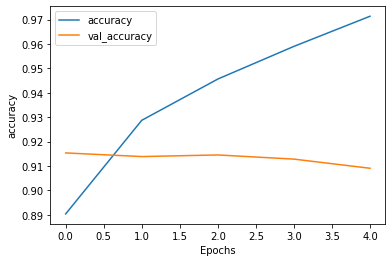

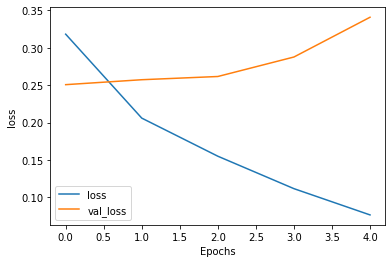

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Verificando o Resultado na base de teste

In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
from sklearn.metrics import accuracy_score
preds_log = model.predict(test_padded)
preds = tf.argmax(preds_log, 1)
print(accuracy_score(y_test, preds))

0.8697368421052631


In [ ]:

from sklearn.metrics import classification_report
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1900
           1       0.95      0.94      0.95      1900
           2       0.91      0.75      0.82      1900
           3       0.75      0.94      0.83      1900

    accuracy                           0.87      7600
   macro avg       0.88      0.87      0.87      7600
weighted avg       0.88      0.87      0.87      7600



In [ ]:
import pandas as pd
pd.crosstab(test_y, preds) #indice, coluna

col_0,0,1,2,3
row_0,,,,
0,1605,57,57,181
1,39,1794,19,48
2,75,26,1434,365
3,35,15,73,1777


Usando Bert

Código baseado no exemplo: https://github.com/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb

In [ ]:
import transformers
from transformers import AutoModel, BertTokenizerFast
import torch
import torch.nn as nn

# para usar GPU
device = torch.device("cuda")


In [ ]:
# puxando BERT pretreinado
bert = AutoModel.from_pretrained('distilbert-base-uncased')


tokenizer = BertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


Token com o Bert

In [ ]:
max_seq_len = 250


tokens_train = tokenizer.batch_encode_plus(
    X_train,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


tokens_val = tokenizer.batch_encode_plus(
    X_val,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


tokens_test = tokenizer.batch_encode_plus(
    X_test,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2187: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:

# inputs que são utilizados no Bert
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train)


val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val)


test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test)

Criação de uma seleção de observações

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#tamanho do batch
batch_size = 128


#Geradores de dataset para treino do modelo

train_data = TensorDataset(train_seq, train_mask, train_y)


train_sampler = RandomSampler(train_data)


train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


val_data = TensorDataset(val_seq, val_mask, val_y)


val_sampler = SequentialSampler(val_data)


val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

Modelo BERT

In [ ]:
# congela o BERT 
# o BERT não será treinado
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      #arquitetura do modelo
      super(BERT_Arch, self).__init__()

      #camada do BERT

      self.bert = bert 
      
      # dropout 
      self.dropout = nn.Dropout(0.1)
      
      # relu 
      self.relu =  nn.ReLU()

      # camada densa
      self.fc1 = nn.Linear(768,128)
      
      # camada densa
      self.fc2 = nn.Linear(128,4)

      #camada de saída
      self.softmax = nn.LogSoftmax(dim=1)

    #função de inferencia
    def forward(self, sent_id, mask):

      
      cls_hs = self.bert(sent_id, attention_mask=mask)
      hidden_state = cls_hs[0]

      pooler = hidden_state[:, 0]
      
      x = self.fc1(pooler)

      x = self.relu(x)

      x = self.dropout(x)

      
      x = self.fc2(x)
      
      
      x = self.softmax(x)

      return x

In [ ]:
# cria o modelo
model = BERT_Arch(bert)

# joga modelo na GPU
model = model.to(device)

In [ ]:
model

BERT_Arch(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_features=

In [ ]:

from transformers import AdamW

# otimizador
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#pesos das classes (aqui todos são iguais)
class_wts = compute_class_weight('balanced', np.unique(y_train), y_train)

print(class_wts)

[1. 1. 1. 1.]


In [ ]:

weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# função de perda
cross_entropy  = nn.NLLLoss(weight=weights) 

# 2 épocas
epochs = 2

Treinamento

In [ ]:
# função de treino
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  
  total_preds=[]
  
  
  for step,batch in enumerate(train_dataloader):
    
    # progresso em cada 50 batches
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # apaga os gradientes
    model.zero_grad()        

    # inferencia
    preds = model(sent_id, mask)

    # perda
    loss = cross_entropy(preds, labels)

    # adiciona a perda
    total_loss = total_loss + loss.item()

    
    loss.backward()

    # limiar para evitar a "explosão" no valor do gradiente
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # atualiza os pesos conforme o gradientes
    optimizer.step()

    # retira a previsão e coloca na CPU
    preds=preds.detach().cpu().numpy()

    
    total_preds.append(preds)

  # perda total
  avg_loss = total_loss / len(train_dataloader)
  
  
  total_preds  = np.concatenate(total_preds, axis=0)


  return avg_loss, total_preds

In [ ]:
# função de validação
def evaluate():
  
  print("\nEvaluating...")
  
  
  model.eval()

  total_loss, total_accuracy = 0, 0
  
 
  total_preds = []

  
  for step,batch in enumerate(val_dataloader):
    
    
    if step % 50 == 0 and not step == 0:
      
      
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # retira o calculo do gradiente
    with torch.no_grad():
      
      # inferencia
      preds = model(sent_id, mask)

      # perda
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # perda total
  avg_loss = total_loss / len(val_dataloader) 

  # previsao total
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:


train_losses=[]
valid_losses=[]

#treino
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #aplica função treino
    train_loss, _ = train()
    
    #valida
    valid_loss, _ = evaluate()
    
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    750.
  Batch   100  of    750.
  Batch   150  of    750.
  Batch   200  of    750.
  Batch   250  of    750.
  Batch   300  of    750.
  Batch   350  of    750.
  Batch   400  of    750.
  Batch   450  of    750.
  Batch   500  of    750.
  Batch   550  of    750.
  Batch   600  of    750.
  Batch   650  of    750.
  Batch   700  of    750.

Evaluating...
  Batch    50  of    188.
  Batch   100  of    188.
  Batch   150  of    188.

Training Loss: 0.342
Validation Loss: 0.278

 Epoch 2 / 2
  Batch    50  of    750.
  Batch   100  of    750.
  Batch   150  of    750.
  Batch   200  of    750.
  Batch   250  of    750.
  Batch   300  of    750.
  Batch   350  of    750.
  Batch   400  of    750.
  Batch   450  of    750.
  Batch   500  of    750.
  Batch   550  of    750.
  Batch   600  of    750.
  Batch   650  of    750.
  Batch   700  of    750.

Evaluating...
  Batch    50  of    188.
  Batch   100  of    188.
  Batch   150  of    188.

Training Los

In [ ]:

#salvar o modelo
torch.save(model.state_dict(), 'saved_weights.pt')

Inferência na base de teste

In [ ]:
# Repetir o passo para o teste
test_data = TensorDataset(test_seq, test_mask, test_y)


test_sampler = SequentialSampler(test_data)


test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [ ]:
total_preds = []


for step,batch in enumerate(test_dataloader):
  
  # progresso da previssão
  if step % 50 == 0 and not step == 0:
    
    
    print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

  
  batch = [t.to(device) for t in batch]

  sent_id, mask, labels = batch

  
  with torch.no_grad():
    
    # inferencia
    preds = model(sent_id, mask)


    preds = preds.detach().cpu().numpy()

    total_preds.append(preds)

# previsao total
total_preds  = np.concatenate(total_preds, axis=0)

  Batch    50  of     60.


Resultados

In [ ]:

from sklearn.metrics import accuracy_score
preds = np.argmax(total_preds, axis = 1)
print(accuracy_score(y_test, preds))

0.8976315789473684


In [ ]:

from sklearn.metrics import classification_report
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1900
           1       0.98      0.96      0.97      1900
           2       0.88      0.82      0.85      1900
           3       0.84      0.91      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



In [ ]:
import pandas as pd
pd.crosstab(test_y, preds)

col_0,0,1,2,3
row_0,,,,
0,1707,29,97,67
1,59,1827,7,7
2,85,6,1550,259
3,53,4,105,1738
